# Supervised Learning Approach

(Insert explanation of our process here)

## Supervised Learning Approach

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras import optimizers
from keras.callbacks import CSVLogger
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook
import os

TIME_STEPS = 10
BATCH_SIZE = 10

### Reading Stock Data

In [3]:
msft = pd.read_csv("./Individual_Stock_Data/MSFT.csv")

In [4]:
msft.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,30.62,31.10,30.59,30.95,24.53,38409100
1,2010-01-05,30.85,31.10,30.64,30.96,24.53,49749600
2,2010-01-06,30.88,31.08,30.52,30.77,24.38,58182400
3,2010-01-07,30.63,30.70,30.19,30.45,24.13,50559700
4,2010-01-08,30.28,30.88,30.24,30.66,24.30,51197400


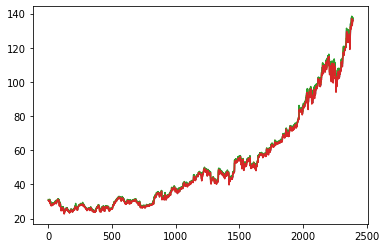

In [5]:
plt.figure()
plt.plot(msft["Open"])
plt.plot(msft["Close"])
plt.plot(msft["High"])
plt.plot(msft["Low"])
plt.show()

### Normalize Data

In [6]:
df_train, df_test = train_test_split(msft, train_size=0.84, test_size=0.16, shuffle=False)

In [7]:
df_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,30.62,31.10,30.59,30.95,24.53,38409100
1,2010-01-05,30.85,31.10,30.64,30.96,24.53,49749600
2,2010-01-06,30.88,31.08,30.52,30.77,24.38,58182400
3,2010-01-07,30.63,30.70,30.19,30.45,24.13,50559700
4,2010-01-08,30.28,30.88,30.24,30.66,24.30,51197400


In [8]:
df_test.head()

,Date,Open,High,Low,Close,Adj Close,Volume
2009,2017-12-26,85.31,85.53,85.03,85.40,83.28,9891200
2010,2017-12-27,85.65,85.98,85.22,85.71,83.58,14678000
2011,2017-12-28,85.90,85.93,85.55,85.72,83.59,10594300
2012,2017-12-29,85.63,86.05,85.50,85.54,83.42,18717400
2013,2018-01-02,86.13,86.31,85.50,85.95,83.82,22483800


In [9]:
train_cols = ["Open", "High", "Low", "Close", "Volume"]
print("Train and Test Size:", len(df_train), len(df_test))
x = df_train.drop(columns=["Date"]).values
min_max_scaler = MinMaxScaler()

# Transforming Data
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.fit_transform(df_test.drop(columns=["Date"]).values)

Train and Test Size: 2009 383


In [10]:
x_train.shape, x_test.shape

((2009, 6), (383, 6))

## Build Time-Series Structure

In [40]:
def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0, dim_1 = mat.shape[0] - TIME_STEPS, mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    for i in range(dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat
    
x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)
print("Test size", x_test_t.shape, y_test_t.shape, x_val.shape, y_val.shape)


length of time-series i/o (1999, 10, 6) (1999,)
length of time-series i/o (373, 10, 6) (373,)
Test size (185, 10, 6) (185,) (185, 10, 6) (185,)


In [47]:
lstm_model = Sequential()
lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,     kernel_initializer='random_uniform'))
lstm_model.add(Dropout(0.4))
lstm_model.add(Dense(20,activation='relu'))
lstm_model.add(Dense(1,activation='sigmoid'))
optimizer = optimizers.RMSprop(lr=0.001)
lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

In [48]:
csv_logger = CSVLogger("stock_supervised.log", append=True)

history = lstm_model.fit(x_t, y_t, epochs=50, verbose=2, batch_size=BATCH_SIZE, #50
                        shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                        trim_dataset(y_val, BATCH_SIZE)), callbacks=[csv_logger])
lstm_model.save("SL_stock_model.h5")

Train on 1990 samples, validate on 180 samples
Epoch 1/50
 - 2s - loss: 0.0052 - val_loss: 0.4530
Epoch 2/50
 - 1s - loss: 0.0171 - val_loss: 0.3255
Epoch 3/50
 - 1s - loss: 0.0117 - val_loss: 0.2411
Epoch 4/50
 - 1s - loss: 0.0084 - val_loss: 0.2105
Epoch 5/50
 - 1s - loss: 0.0065 - val_loss: 0.1642
Epoch 6/50
 - 1s - loss: 0.0049 - val_loss: 0.1477
Epoch 7/50
 - 1s - loss: 0.0044 - val_loss: 0.1396
Epoch 8/50
 - 1s - loss: 0.0037 - val_loss: 0.1449
Epoch 9/50
 - 1s - loss: 0.0039 - val_loss: 0.1367
Epoch 10/50
 - 1s - loss: 0.0034 - val_loss: 0.1208
Epoch 11/50
 - 1s - loss: 0.0031 - val_loss: 0.1065
Epoch 12/50
 - 1s - loss: 0.0025 - val_loss: 0.1395
Epoch 13/50
 - 1s - loss: 0.0033 - val_loss: 0.0868
Epoch 14/50
 - 1s - loss: 0.0022 - val_loss: 0.0808
Epoch 15/50
 - 1s - loss: 0.0024 - val_loss: 0.0548
Epoch 16/50
 - 1s - loss: 0.0014 - val_loss: 0.0514
Epoch 17/50
 - 1s - loss: 0.0011 - val_loss: 0.0341
Epoch 18/50
 - 1s - loss: 9.8432e-04 - val_loss: 0.0288
Epoch 19/50
 - 1s - lo

In [49]:
from keras.models import load_model

y_pred = lstm_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)

# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]

print(y_pred_org[0:15])
print(y_test_t_org[0:15])

Error is 0.005234703018333629 (180,) (180,)
[116.31482  115.34651  113.677475 112.71896  113.69674  110.90965
 107.664    111.211044 111.5651   112.596825 113.59644  111.754135
 110.91484  111.70101  110.35145 ]
[112.79 112.13 110.85 112.26 106.16 105.91 109.57 107.6  111.   110.71
 108.5  108.66 109.63 108.1  102.32]


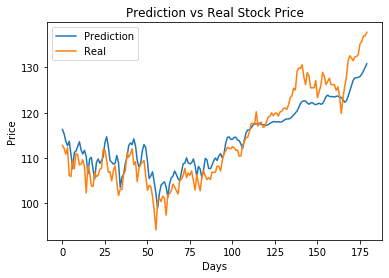

<Figure size 432x288 with 0 Axes>

In [50]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()
plt.savefig('pred_vs_real_BS_.png')


In [51]:
from keras import backend as K

def coeff_determination(y_true, y_pred):

    SS_res =K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - np.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

R_2 = coeff_determination(y_test_t_org, y_pred_org)
with tf.Session() as sess:  
    print(R_2.eval()) 


0.8534011636257696


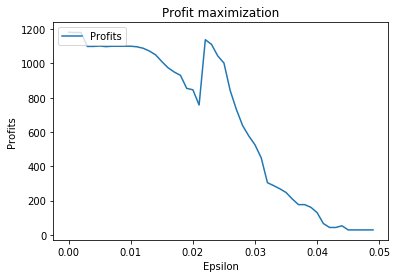

Max Profits: 1181.5100000000016


In [52]:
y_pred = y_pred_org
y = y_test_t_org
positions = [y[0]]
profits = []
max_len_p = 0
eps = 0.02 # Vary this between 0.01 and 0.05 to maximize profit
epsilons = np.arange(0, 0.05, .001)
max_pos = []
for eps in epsilons:
    profit= 0
    for t in range(1,len(y)):
        if y_pred[t] > y[t-1] + eps*y[t-1]:
            positions.append(y[t])
        elif y_pred[t] < y[t-1] - eps*y[t-1]:
            for p in positions:
                profit += (y[t] - p)
            positions = []
        max_len_p = max(max_len_p, len(positions))
    profits.append(profit)
    max_pos.append(max_len_p)

plt.figure()
plt.plot(epsilons, profits)
plt.title('Profit maximization')
plt.ylabel('Profits')
plt.xlabel('Epsilon')
plt.legend(['Profits', 'Epsilon'], loc='upper left')
plt.show()
print("Max Profits:", max(profits))

If we change the epsilon value, we essentially change the range we can choose whether or not to buy or sell at, rather than hold. From these results, we can see that our maximum epsilon value is around 0.02, so we buy a stock when our predicted price is more than 2% higher than what it was the day before, and we sell if our maximum epsilon value is around 2% lower.  